# Import Library

In [4]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer
import torch.nn.functional as F
import torch.nn as nn
import re
from cuml.manifold import UMAP
# import hdbscan
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from cuml.cluster import HDBSCAN
from cuml.manifold import TSNE
import cupy as cp

## Import fancyzhx/dbpedia_14 dataset

In [5]:
splits = {'train': 'dbpedia_14/train-00000-of-00001.parquet', 'test': 'dbpedia_14/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/fancyzhx/dbpedia_14/" + splits["train"])
df.head()

,label,title,content
0,0,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,0,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,0,Q-workshop,Q-workshop is a Polish company located in Poz...
3,0,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,0,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [6]:
df["text"] = "Title:\n" + df["title"] + "\nContent:\n" + df["content"]
df = df.drop(columns={"title", "content"})

In [7]:
df["id"] = range(1, len(df) + 1)
df.head()

,label,text,id
0,0,Title:\nE. D. Abbott Ltd\nContent:\n Abbott of...,1
1,0,Title:\nSchwan-Stabilo\nContent:\n Schwan-STAB...,2
2,0,Title:\nQ-workshop\nContent:\n Q-workshop is a...,3
3,0,Title:\nMarvell Software Solutions Israel\nCon...,4
4,0,Title:\nBergan Mercy Medical Center\nContent:\...,5


In [8]:
df0 = df[df["label"] == 0]
df1 = df[df["label"] == 1]
df2 = df[df["label"] == 2]
df3 = df[df["label"] == 3]
df4 = df[df["label"] == 4]
df5 = df[df["label"] == 5]
df6 = df[df["label"] == 6]
df7 = df[df["label"] == 7]
df8 = df[df["label"] == 8]
df9 = df[df["label"] == 9]
df10 = df[df["label"] == 10]
df11 = df[df["label"] == 11]
df12 = df[df["label"] == 12]
df13 = df[df["label"] == 13]

In [10]:
df0 = df0.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df1 = df1.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df2 = df2.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df3 = df3.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df4 = df4.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)

from sklearn.model_selection import train_test_split

def stratified_half_split(df, label_col="label", random_state=42):
    parts_0, parts_1 = [], []
    for _, g in df.groupby(label_col):
        g0, g1 = train_test_split(g, test_size=0.5, random_state=random_state)
        parts_0.append(g0)
        parts_1.append(g1)
    return pd.concat(parts_0).reset_index(drop=True), pd.concat(parts_1).reset_index(drop=True)

df5_0, df5_1 = stratified_half_split(df5, label_col="label")
df6_0, df6_1 = stratified_half_split(df6, label_col="label")

df7 = df7.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df8 = df8.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df9 = df9.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df10 = df10.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df11 = df11.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df12 = df12.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)
df13 = df13.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.5, random_state=42)
)

/tmp/ipykernel_36/2030233578.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df0 = df0.groupby("label", group_keys=False).apply(
/tmp/ipykernel_36/2030233578.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby("label", group_keys=False).apply(
/tmp/ipykernel_36/2030233578.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and

In [11]:
df = pd.concat([df0, df1, df2, df3, df4, df5_0, df6_0, df7, df8, df9, df10, df11, df12, df13])
df["label"].value_counts()

label
5     20000
10    20000
9     20000
8     20000
7     20000
6     20000
12    20000
11    20000
13    20000
4     10000
0     10000
3     10000
2     10000
1     10000
Name: count, dtype: int64

## Embedding

In [12]:
ids = df["id"].tolist()
texts = df["text"].tolist()
labels = df["label"].tolist()

In [15]:
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embedding_model.tokenizer.model_max_length = 512
embedding_model.tokenizer.truncation_size = 'right'
embedding = embedding_model.encode(
    texts,
    convert_to_tensor=True,
    show_progress_bar=True,
    device_map="auto",
    fp16=True
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7188 [00:00<?, ?it/s]

In [16]:
label2id = {
    "company": 0,
    "educational_institution": 1,
    "artist": 2,
    "athlete": 3,
    "office_holder": 4,
    "mean_of_transportation": 5, 
    "building": 6,
    "natural_place": 7,
    "village": 8,
    "animal": 9,
    "plant": 10,
    "album": 11,
    "film": 12,
    "written_work": 13
}
id2label = {v: k for k, v in label2id.items()}

## Plot TSNE

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-08-20 07:56:32.151] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/tmp/ipykernel_36/1379496773.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_classes)


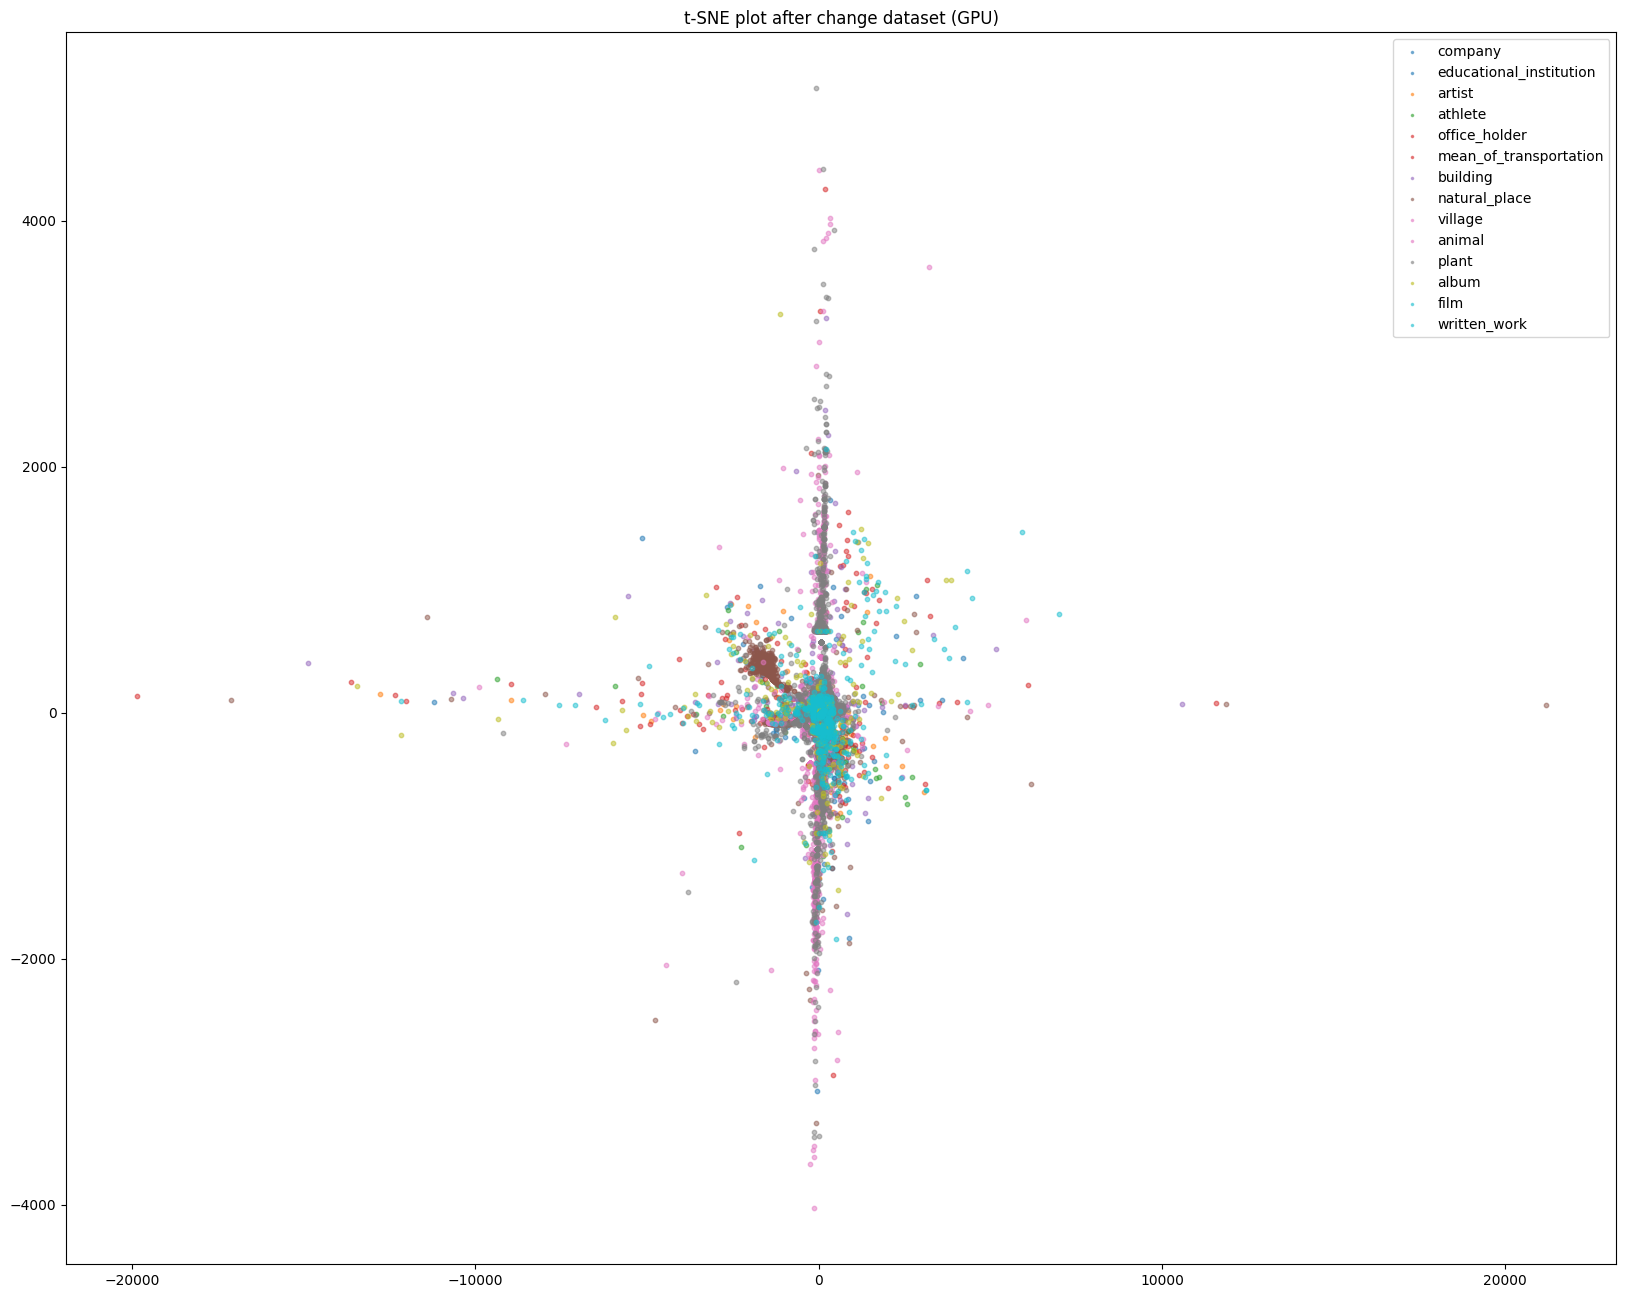

In [17]:
emb_gpu = cp.asarray(embedding.cpu().numpy())

tsne_model = TSNE(n_components=2, perplexity=50, random_state=42)
emb_tsne = tsne_model.fit_transform(emb_gpu)

emb_tsne = cp.asnumpy(emb_tsne)

labels = df["label"].tolist()

plt.figure(figsize=(20, 16))
num_classes = len(set(labels))
cmap = plt.cm.get_cmap('tab10', num_classes)

for label in set(labels):
    mask = np.array(labels) == label
    plt.scatter(emb_tsne[mask, 0],
                emb_tsne[mask, 1],
                s=10,
                alpha=0.5,
                color=cmap(label),
                label=id2label[label])

plt.legend(markerscale=0.5)
plt.title("t-SNE plot after change dataset (GPU)")
plt.show()

## UMAP and HDBSCAN

In [ ]:
# Umap
emb_np = embedding.cpu().numpy()
umap = umap.UMAP(n_components=2, n_neighbors=100, random_state=42)
emb_umap = reducer.fit_transform(emb_np)

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=200)
cluster_labels = clusterer.fit_predict(emb_umap)

df_umap = pd.DataFrame(emb_umap, columns=['UMAP-1', 'UMAP-2'])
df_umap['cluster'] = cluster_labels
df_umap['id'] = ids
df_umap['label'] = labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP-1', y='UMAP-2', hue='cluster', palette='tab20', s=30, legend='full')
plt.title('UMAP + HDBSCAN Clustering with noise')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
embedding_df = pd.DataFrame(
    emb_umap,
    columns=[f"embedding_{i}" for i in range(emb_umap.shape[1])]
)
embedding_df["id"] = ids

df_umap = df_umap.merge(embedding_df, on="id")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP-1', y='UMAP-2', hue='cluster', palette='tab20', s=30, legend='full')
plt.title('UMAP + HDBSCAN Clustering without noise')
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
# emb_np = embedding.cpu().numpy()
umap = UMAP(n_components=64, n_neighbors=200, random_state=42)
emb_umap = umap.fit_transform(embedding)

[2025-08-17 18:33:17.207] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [108]:
# HDBSCAN
clusterer = HDBSCAN(min_cluster_size=500)
cluster_labels = clusterer.fit_predict(emb_umap)

In [109]:
def to_numpy(x):
    return x.get() if hasattr(x, "get") else x

emb_umap_np = to_numpy(emb_umap)
cluster_labels_np = to_numpy(cluster_labels)

embedding_cols = [f"embedding_{i}" for i in range(emb_umap_np.shape[1])]
df_full = pd.DataFrame(emb_umap_np, columns=embedding_cols)
df_full["id"] = ids
df_full["label"] = labels
df_full["cluster"] = cluster_labels_np

In [110]:
df_full["cluster"].value_counts()

cluster
 0     59927
 4     20699
 8     13177
-1     12146
 1     11439
 11     4761
 5      4266
 10     3419
 6      2727
 12     1824
 2      1782
 7      1564
 3      1192
 9      1077
Name: count, dtype: int64

## Model in each clusters

In [121]:
valid_clusters = sorted(c for c in df_full["cluster"].unique() if c != -1)
models = {}

for cluster_id in valid_clusters:
    X_cluster = df_full[df_full["cluster"] == cluster_id][embedding_cols].values

    model = IsolationForest(
        n_estimators=200,
        contamination=0.1,
        random_state=42,
        n_jobs=-1
    )

    print(f"Training IsolationForest for cluster {cluster_id} with {len(X_cluster)} samples.")
    model.fit(X_cluster)
    models[cluster_id] = model

print(f"Finished training {len(models)} IsolationForest models.")


# valid_clusters = sorted(c for c in df_full["cluster"].unique() if c != -1)
# models = {}

# for cluster_id in valid_clusters:
#     X_cluster = df_full[df_full["cluster"] == cluster_id][embedding_cols].values

#     model = OneClassSVM(
#         kernel="rbf",
#         gamma="scale",
#         nu=0.05
#     )

#     print(f"Training OneClassSVM for cluster {cluster_id} with {len(X_cluster)} samples.")
#     model.fit(X_cluster)
#     models[cluster_id] = model

# print(f"Finished training {len(models)} OneClassSVM models.")

Training IsolationForest for cluster 0 with 59927 samples.
Training IsolationForest for cluster 1 with 11439 samples.
Training IsolationForest for cluster 2 with 1782 samples.
Training IsolationForest for cluster 3 with 1192 samples.
Training IsolationForest for cluster 4 with 20699 samples.
Training IsolationForest for cluster 5 with 4266 samples.
Training IsolationForest for cluster 6 with 2727 samples.
Training IsolationForest for cluster 7 with 1564 samples.
Training IsolationForest for cluster 8 with 13177 samples.
Training IsolationForest for cluster 9 with 1077 samples.
Training IsolationForest for cluster 10 with 3419 samples.
Training IsolationForest for cluster 11 with 4761 samples.
Training IsolationForest for cluster 12 with 1824 samples.
Finished training 13 IsolationForest models.


## Inference phase

In [112]:
df7 = df7.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df8 = df8.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df9 = df9.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df10 = df10.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df11 = df11.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df12 = df12.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)
df13 = df13.groupby("label", group_keys=False).apply(
    lambda g: g.sample(frac=0.05, random_state=42)
)

/tmp/ipykernel_702/4213155291.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df7 = df7.groupby("label", group_keys=False).apply(
/tmp/ipykernel_702/4213155291.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df8 = df8.groupby("label", group_keys=False).apply(
/tmp/ipykernel_702/4213155291.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, 

In [113]:
# splits = {'train': 'dbpedia_14/train-00000-of-00001.parquet', 'test': 'dbpedia_14/test-00000-of-00001.parquet'}
# df_test = pd.read_parquet("hf://datasets/fancyzhx/dbpedia_14/" + splits["test"])
# df_test.head()

df_test = pd.concat([df7, df8, df9, df10, df11, df12, df13, df5_1, df6_1])

In [47]:
# df_test["text"] = "Title:\n" + df_test["title"] + "\nContent:\n" + df_test["content"]
# df_test["id"] = range(1, len(df_test) + 1)
# df_test = df_test.drop(columns={"title", "content"})

In [114]:
df_test['label'].value_counts()

label
5     20000
6     20000
7      2000
8      2000
9      2000
11     2000
10     2000
13     2000
12     2000
Name: count, dtype: int64

In [115]:
ids_test = df_test["id"].tolist()
texts_test = df_test["text"].tolist()
labels_test = df_test["label"].tolist()

In [116]:
embedding_test = embedding_model.encode(
    texts_test,
    convert_to_tensor=True,
    show_progress_bar=True,
    device="cuda"
)

Batches:   0%|          | 0/1688 [00:00<?, ?it/s]

In [117]:
emb_umap_test = umap.transform(embedding_test)

In [ ]:
# results = {}

# for cluster_id, model in models.items():
#     try:
#         preds = model.predict(emb_umap)
#         pos_count = np.sum(preds == 1)
#         neg_count = np.sum(preds == -1)

#         results[cluster_id] = {
#             "positive": int(pos_count),
#             "negative": int(neg_count)
#         }
#     except Exception as e:
#         results[cluster_id] = {"error": str(e)}

In [122]:
remaining_idx = np.arange(len(emb_umap_test))
remaining_data = emb_umap_test.copy()

if hasattr(remaining_data, "get"):
    remaining_data = remaining_data.get()

for cluster_id, model in models.items():
    preds = model.predict(remaining_data)

    pos_mask = preds == 1
    neg_mask = preds == -1

    print(f"Cluster {cluster_id}: {np.sum(pos_mask)} inliers removed, {np.sum(neg_mask)} passed to next model.")

    remaining_idx = remaining_idx[neg_mask]
    remaining_data = remaining_data[neg_mask]

print(f"Remaining samples after all models: {len(remaining_idx)}")

Cluster 0: 492 inliers removed, 53508 passed to next model.
Cluster 1: 1324 inliers removed, 52184 passed to next model.
Cluster 2: 267 inliers removed, 51917 passed to next model.
Cluster 3: 2 inliers removed, 51915 passed to next model.
Cluster 4: 55 inliers removed, 51860 passed to next model.
Cluster 5: 378 inliers removed, 51482 passed to next model.
Cluster 6: 221 inliers removed, 51261 passed to next model.
Cluster 7: 3 inliers removed, 51258 passed to next model.
Cluster 8: 12 inliers removed, 51246 passed to next model.
Cluster 9: 81 inliers removed, 51165 passed to next model.
Cluster 10: 371 inliers removed, 50794 passed to next model.
Cluster 11: 447 inliers removed, 50347 passed to next model.
Cluster 12: 138 inliers removed, 50209 passed to next model.
Remaining samples after all models: 50209


In [123]:
print("Remaining data embeddings:")
print(remaining_data)

print("Remaining indices:")
print(remaining_idx)

remaining_df = df_test.iloc[remaining_idx]
print("Remaining original rows:")
print(remaining_df)

Remaining data embeddings:
[[-0.19450939 -0.1083235   0.05275071 ... -0.13305819 -0.00865552
  -0.13014063]
 [ 0.03334883 -0.3094527  -1.063663   ... -0.16958044 -0.6201203
  -0.27525344]
 [-0.17955112 -0.18622795 -0.40966094 ... -0.1427029  -0.32376623
  -0.24657479]
 ...
 [ 0.0630126   0.36460114 -0.65910196 ... -0.47860897 -0.46342617
  -0.2720762 ]
 [ 0.11039913 -0.35861215 -0.54983354 ... -0.04849613 -0.2496543
  -0.48755193]
 [-0.01898082 -0.15775107 -0.685999   ... -0.2071274  -0.31584767
  -0.313886  ]]
Remaining indices:
[    0     1     2 ... 53997 53998 53999]
Remaining original rows:
        label                                               text      id
312823      7  Title:\nHedströmmen\nContent:\n Hedströmmen is...  312824
296298      7  Title:\nGooseneck Glacier\nContent:\n Goosenec...  296299
308505      7  Title:\nChiascio\nContent:\n The Chiascio is a...  308506
286689      7  Title:\nLee (Vechte)\nContent:\n Lee is a rive...  286690
306893      7  Title:\nMcClellan

In [120]:
remaining_df["label"].value_counts()

label
6     18748
5     17659
10     1977
7      1952
9      1935
8      1926
11     1865
13     1757
12     1679
Name: count, dtype: int64